In [1]:
import xarray as xr
import datetime
import numpy as np
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import rasterio
from shapely.geometry import Point
import geopandas as gpd
import os
import glob
from zipfile import ZipFile
import pandas as pd
import matplotlib.pylab as plt
import shapely
import xesmf as xe

In [2]:
toposcale_path = '/Users/jacobqs/Downloads/TopoSCALE_BG.nc'

In [3]:
ds = xr.open_mfdataset(toposcale_path)

In [4]:
cn = ds.cn.values.astype('int') -1 
T_cn = ds.T.sel(clusters = cn)
lonp = ds.lonp.values
latp = ds.latp.values

/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [5]:
df = pd.DataFrame()
df['lonp'] = lonp
df['latp'] = latp
df['cn'] = cn

## Making a pyproj object for UTM Zone 45N

crs_4326 = CRS.from_epsg(4326) # Lat-lon
crs_32645 = CRS.from_epsg(32645) # CRS 

## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_4326, crs_32645, always_xy = True)

x, y = transformer.transform(lonp, latp)

df['x'] = x
df['y'] = y

# # Extracting only data within the area of interest
# x_min = np.min(x)
# x_max = np.max(x)
# y_min = np.min(y)
# y_max = np.max(y)

# x_min_grid = x_min - 500
# x_max_grid = x_max + 500
# y_min_grid = y_min - 500
# y_max_grid = y_max + 500

# x_grid = np.arange(x_min_grid, x_max_grid, 1000)
# y_grid = np.arange(y_min_grid, y_max_grid, 1000)

# df['x_grid'] = np.nan
# df['y_grid'] = np.nan

# # for i, val in enumerate(df['x']):
# #     x_dist = np.abs(df['x'][i] - x_grid)
# #     x_min_dist_inx = np.where(x_dist == np.min(x_dist))[0]
# #     df.loc[i, 'x_grid'] = x_grid[x_min_dist_inx]
# #     y_dist = np.abs(df['y'][i] - y_grid)
# #     y_min_dist_inx = np.where(y_dist == np.min(y_dist))[0]
# #     df.loc[i, 'y_grid'] = y_grid[y_min_dist_inx]

In [6]:
crs = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y),
                       crs = crs)
xmin, ymin, xmax, ymax = gdf.total_bounds

In [7]:
# cell size
cell_size = 1000
# create the cells in a loop
grid_cells = []
xs = []
ys = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
        xs.append((x1-x0)/2 + x0)
        ys.append((y1-y0)/2 + y0)
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

(246934.6138316556, 328277.593637801, 3095219.1259524855, 3208656.1876391307)

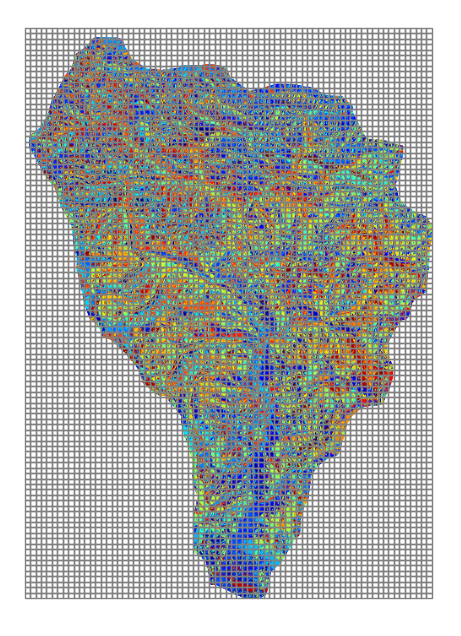

In [11]:
ax = gdf.plot(markersize=.1, figsize=(12, 8), column='cn', cmap='jet')
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [8]:
merged = gpd.sjoin(gdf, cell, how='left', op='within')

/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [42]:
merged_copy = merged.copy()

In [46]:
def get_regridded(merged, ds):
    regridded = dict()
    t = ds.t.values
    cn = ds.cn.values.astype('int') -1 
    for i in t:
        merged_copy = merged.copy()
        ds_slice = ds.sel(t = i)
        merged_copy['T'] = ds_slice.sel(clusters = cn).T * 0.01
        df_count = pd.DataFrame(merged_copy.groupby(['index_right', 'cn', 'T']).size()).rename(columns={0:'count'})
        df_count['proportion'] = df_count.groupby(level=0).transform(lambda x: x/x.sum())
        temps = []
        for j in range(len(df_count)):
            temp = df_count.index[j][2]
            temps.append(temp)
        df_count['temp'] = temps
        df_count['T_scaled'] = df_count['temp'] * df_count['proportion']
        temperature = df_count.groupby(level=0).sum('T_scaled')['T_scaled'].values
        regridded[i] = temperature
    return regridded

In [47]:
temp_regridded = get_regridded(merged, ds)

KeyboardInterrupt: 

In [50]:
T = ds.sel(clusters = cn).T * 0.01

/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [52]:
T

<xarray.DataArray 'T' (t: 149016, clusters: 571612)>
dask.array<mul, shape=(149016, 571612), dtype=float64, chunksize=(149016, 571612), chunktype=numpy.ndarray>
Dimensions without coordinates: t, clusters

In [53]:
iterables = [T.t.values, T.clusters.values]

In [56]:
pd.MultiIndex.from_product(iterables, names=["t", "clusters"])

: 

: 

In [51]:
df = pd.DataFrame()


<xarray.DataArray 'T' (t: 149016, clusters: 571612)>
dask.array<mul, shape=(149016, 571612), dtype=float64, chunksize=(149016, 571612), chunktype=numpy.ndarray>
Dimensions without coordinates: t, clusters

In [10]:
ds0 = ds.sel(t=0)

In [17]:
merged_copy['T'] = ds0.sel(clusters = cn).T * 0.01

In [18]:
merged_copy

,lonp,latp,cn,x,y,geometry,index_right,T
0,84.446250,28.772500,103,250677.618451,3.185457e+06,POINT (250677.618 3185456.567),190.0,-16.58
1,84.446250,28.771667,103,250675.635417,3.185364e+06,POINT (250675.635 3185364.194),189.0,-16.58
2,84.446250,28.770833,103,250673.652435,3.185272e+06,POINT (250673.652 3185271.821),189.0,-16.58
3,84.446250,28.770000,103,250671.669507,3.185179e+06,POINT (250671.670 3185179.449),189.0,-16.58
4,84.446250,28.769167,43,250669.686631,3.185087e+06,POINT (250669.687 3185087.076),189.0,-21.41
...,...,...,...,...,...,...,...,...
571607,85.205417,28.618333,88,324553.847873,3.167018e+06,POINT (324553.848 3167017.724),7836.0,-17.31
571608,85.205417,28.617500,59,324552.462054,3.166925e+06,POINT (324552.462 3166925.379),7836.0,-19.39
571609,85.205417,28.616667,42,324551.076273,3.166833e+06,POINT (324551.076 3166833.033),7836.0,-16.37
571610,85.205417,28.615833,42,324549.690529,3.166741e+06,POINT (324549.691 3166740.687),7836.0,-16.37


In [21]:
# Make dataframe that has the merged['index_right] and merged['cn'] as multindex, and the count of cn as the value
# Rename the column to 'count'  
df_count = pd.DataFrame(merged_copy.groupby(['index_right', 'cn', 'T']).size()).rename(columns={0:'count'})

In [22]:
df_count

count
index_right cn  T            
186.0       33  -18.24      3
            103 -16.58     10
187.0       14  -15.63      5
            33  -18.24     63
            34  -17.67      4
...                       ...
7839.0      110 -15.37      1
            133 -14.15      1
            135 -15.61     10
            152 -16.62      3
            171 -14.06      1

[65862 rows x 1 columns]

In [23]:
# Add a new column to df_count that is the percentage of the total count for each cluster
df_count['proportion'] = df_count.groupby(level=0).transform(lambda x: x/x.sum())

In [24]:
df_count

count  proportion
index_right cn  T                        
186.0       33  -18.24      3    0.230769
            103 -16.58     10    0.769231
187.0       14  -15.63      5    0.050505
            33  -18.24     63    0.636364
            34  -17.67      4    0.040404
...                       ...         ...
7839.0      110 -15.37      1    0.024390
            133 -14.15      1    0.024390
            135 -15.61     10    0.243902
            152 -16.62      3    0.073171
            171 -14.06      1    0.024390

[65862 rows x 2 columns]

In [31]:
temps = []
for i in range(len(df_count)):
    temp = df_count.index[i][2]
    temps.append(temp)


In [32]:
df_count['temp'] = temps

In [34]:
df_count

count  proportion   temp
index_right cn  T                               
186.0       33  -18.24      3    0.230769 -18.24
            103 -16.58     10    0.769231 -16.58
187.0       14  -15.63      5    0.050505 -15.63
            33  -18.24     63    0.636364 -18.24
            34  -17.67      4    0.040404 -17.67
...                       ...         ...    ...
7839.0      110 -15.37      1    0.024390 -15.37
            133 -14.15      1    0.024390 -14.15
            135 -15.61     10    0.243902 -15.61
            152 -16.62      3    0.073171 -16.62
            171 -14.06      1    0.024390 -14.06

[65862 rows x 3 columns]

In [35]:
df_count['T_scaled'] = df_count['temp'] * df_count['proportion']

In [40]:
temperature = df_count.groupby(level=0).sum('T_scaled')['T_scaled'].values